In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

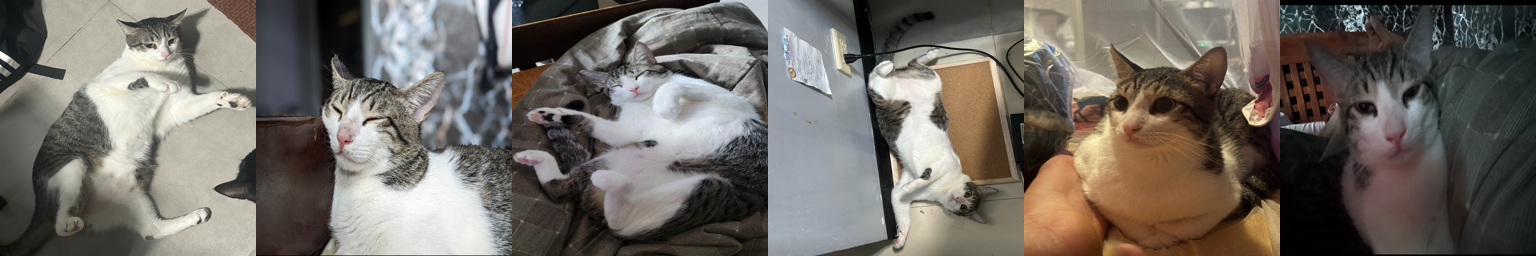

In [2]:
import glob
# test#
imgs = [Image.open(path) for path in glob.glob("./images_1/*.PNG")]
image_grid(imgs, 1, len(imgs))

# Train

In [4]:
from diffusers.loaders import LoraLoaderMixin

/opt/conda/envs/cvssd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import argparse
import gc
import hashlib
import itertools
import logging
import math
import os
import shutil
import warnings
from pathlib import Path
from typing import Dict

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from huggingface_hub import create_repo, upload_folder
from packaging import version
from PIL import Image
from PIL.ImageOps import exif_transpose
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DPMSolverMultistepScheduler,
    StableDiffusionXLPipeline,
    UNet2DConditionModel,
)
#from diffusers.loaders import LoraLoaderMixin, text_encoder_lora_state_dict
from diffusers.models.attention_processor import LoRAAttnProcessor, LoRAAttnProcessor2_0
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available

logger = get_logger(__name__)

def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")


In [6]:
from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path="segmind/SSD-1B",
    pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix",
    revision=None,
    instance_data_dir="images_1/",
    class_data_dir=None,
    instance_prompt="a photo of hawhaw cat",
    class_prompt=None,
    validation_prompt=None,
    num_validation_images=4,
    validation_epochs=50,
    with_prior_preservation=False,
    prior_loss_weight=1.0,
    num_class_images=100,
    output_dir="dreambooth_lora_model",
    seed=None,
    resolution=1024,
    crops_coords_top_left_h=0,
    crops_coords_top_left_w=0,
    center_crop=False,
    train_text_encoder=False,
    train_batch_size=2,
    sample_batch_size=4,
    num_train_epochs=1,
    max_train_steps=200,
    checkpointing_steps=717,
    checkpoints_total_limit=None,
    resume_from_checkpoint=None,
    gradient_accumulation_steps=2,
    gradient_checkpointing=False,
    learning_rate=1e-4,
    scale_lr=False,
    lr_scheduler="constant",
    lr_warmup_steps=0,
    lr_num_cycles=1,
    lr_power=1.0,
    dataloader_num_workers=0,
    use_8bit_adam=True,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_weight_decay=1e-2,
    adam_epsilon=1e-08,
    max_grad_norm=1.0,
    logging_dir="logs",
    allow_tf32=False,
    report_to="tensorboard",
    mixed_precision="fp16",
    prior_generation_precision=None,
    local_rank=-1,
    enable_xformers_memory_efficient_attention=False,
    rank=4
)
args

Namespace(pretrained_model_name_or_path='segmind/SSD-1B', pretrained_vae_model_name_or_path='madebyollin/sdxl-vae-fp16-fix', revision=None, instance_data_dir='images_1/', class_data_dir=None, instance_prompt='a photo of hawhaw cat', class_prompt=None, validation_prompt=None, num_validation_images=4, validation_epochs=50, with_prior_preservation=False, prior_loss_weight=1.0, num_class_images=100, output_dir='dreambooth_lora_model', seed=None, resolution=1024, crops_coords_top_left_h=0, crops_coords_top_left_w=0, center_crop=False, train_text_encoder=False, train_batch_size=2, sample_batch_size=4, num_train_epochs=1, max_train_steps=200, checkpointing_steps=717, checkpoints_total_limit=None, resume_from_checkpoint=None, gradient_accumulation_steps=2, gradient_checkpointing=False, learning_rate=0.0001, scale_lr=False, lr_scheduler='constant', lr_warmup_steps=0, lr_num_cycles=1, lr_power=1.0, dataloader_num_workers=0, use_8bit_adam=True, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=

In [7]:
class DreamBoothDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images.
    """

    def __init__(
        self,
        instance_data_root,
        class_data_root=None,
        class_num=None,
        size=args.resolution,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(self.class_data_root.iterdir())
            if class_num is not None:
                self.num_class_images = min(len(self.class_images_path), class_num)
            else:
                self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        instance_image = exif_transpose(instance_image)

        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            class_image = exif_transpose(class_image)

            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)

        return example


def collate_fn(examples, with_prior_preservation=False):
    pixel_values = [example["instance_images"] for example in examples]

    # Concat class and instance examples for prior preservation.
    # We do this to avoid doing two forward passes.
    if with_prior_preservation:
        pixel_values += [example["class_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    batch = {"pixel_values": pixel_values}
    return batch


class PromptDataset(Dataset):
    "A simple dataset to prepare the prompts to generate class images on multiple GPUs."

    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example


def tokenize_prompt(tokenizer, prompt):
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    return text_input_ids


# Adapted from pipelines.StableDiffusionXLPipeline.encode_prompt
def encode_prompt(text_encoders, tokenizers, prompt, text_input_ids_list=None):
    prompt_embeds_list = []

    for i, text_encoder in enumerate(text_encoders):
        if tokenizers is not None:
            tokenizer = tokenizers[i]
            text_input_ids = tokenize_prompt(tokenizer, prompt)
        else:
            assert text_input_ids_list is not None
            text_input_ids = text_input_ids_list[i]

        prompt_embeds = text_encoder(
            text_input_ids.to(text_encoder.device),
            output_hidden_states=True,
        )

        # We are only ALWAYS interested in the pooled output of the final text encoder
        pooled_prompt_embeds = prompt_embeds[0]
        prompt_embeds = prompt_embeds.hidden_states[-2]
        bs_embed, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.view(bs_embed, seq_len, -1)
        prompt_embeds_list.append(prompt_embeds)

    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
    pooled_prompt_embeds = pooled_prompt_embeds.view(bs_embed, -1)
    return prompt_embeds, pooled_prompt_embeds


def unet_attn_processors_state_dict(unet) -> Dict[str, torch.tensor]:
    """
    Returns:
        a state dict containing just the attention processor parameters.
    """
    attn_processors = unet.attn_processors

    attn_processors_state_dict = {}

    for attn_processor_key, attn_processor in attn_processors.items():
        for parameter_key, parameter in attn_processor.state_dict().items():
            attn_processors_state_dict[f"{attn_processor_key}.{parameter_key}"] = parameter

    return attn_processors_state_dict

In [8]:
logging_dir = Path(args.output_dir, args.logging_dir)

accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    project_config=accelerator_project_config,
)

# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# If passed along, set the training seed now.
if args.seed is not None:
    set_seed(args.seed)

/opt/conda/envs/cvssd/lib/python3.10/site-packages/accelerate/accelerator.py:384: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
Detected kernel version 4.19.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
04/22/2024 04:46:09 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16



In [9]:
# Handle the repository creation
if accelerator.is_main_process:
    if args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)

# Load the tokenizers
tokenizer_one = AutoTokenizer.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision, use_fast=False
)
tokenizer_two = AutoTokenizer.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="tokenizer_2", revision=args.revision, use_fast=False
)

# import correct text encoder classes
text_encoder_cls_one = import_model_class_from_model_name_or_path(
    args.pretrained_model_name_or_path, args.revision
)
text_encoder_cls_two = import_model_class_from_model_name_or_path(
    args.pretrained_model_name_or_path, args.revision, subfolder="text_encoder_2"
)


You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


In [10]:
# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
text_encoder_one = text_encoder_cls_one.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)
text_encoder_two = text_encoder_cls_two.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder_2", revision=args.revision
)
vae_path = (
    args.pretrained_model_name_or_path
    if args.pretrained_vae_model_name_or_path is None
    else args.pretrained_vae_model_name_or_path
)
vae = AutoencoderKL.from_pretrained(
    vae_path, subfolder="vae" if args.pretrained_vae_model_name_or_path is None else None, revision=args.revision
)
unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision
)

# We only train the additional adapter LoRA layers
vae.requires_grad_(False)
text_encoder_one.requires_grad_(False)
text_encoder_two.requires_grad_(False)
unet.requires_grad_(False)
print("Lora Adapter Success (printing here so that the full architecture won't show")

{'thresholding', 'clip_sample_range', 'dynamic_thresholding_ratio', 'variance_type'} was not found in config. Values will be initialized to default values.
{'dropout', 'attention_type'} was not found in config. Values will be initialized to default values.


Lora Adapter Success (printing here so that the full architecture won't show


In [11]:
# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move unet, vae and text_encoder to device and cast to weight_dtype
unet.to(accelerator.device, dtype=weight_dtype)

# The VAE is always in float32 to avoid NaN losses.
vae.to(accelerator.device, dtype=torch.float32)

text_encoder_one.to(accelerator.device, dtype=weight_dtype)
text_encoder_two.to(accelerator.device, dtype=weight_dtype)
print("Accelerator Success (printing here so that the full architecture won't show")

Accelerator Success (printing here so that the full architecture won't show


In [12]:
# now we will add new LoRA weights to the attention layers
# Set correct lora layers
unet_lora_attn_procs = {}
unet_lora_parameters = []
for name, attn_processor in unet.attn_processors.items():
    cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]

    lora_attn_processor_class = (
        LoRAAttnProcessor2_0 if hasattr(F, "scaled_dot_product_attention") else LoRAAttnProcessor
    )
    module = lora_attn_processor_class(
        hidden_size=hidden_size, cross_attention_dim=cross_attention_dim, rank=args.rank
    )
    unet_lora_attn_procs[name] = module
    unet_lora_parameters.extend(module.parameters())

unet.set_attn_processor(unet_lora_attn_procs)

In [13]:
# The text encoder comes from 🤗 transformers, so we cannot directly modify it.
# So, instead, we monkey-patch the forward calls of its attention-blocks.
# Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
if args.use_8bit_adam: # make it true
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
        )

    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

# Optimizer creation
params_to_optimize = (
    itertools.chain(unet_lora_parameters, text_lora_parameters_one, text_lora_parameters_two)
    if args.train_text_encoder
    else unet_lora_parameters
)
optimizer = optimizer_class(
    params_to_optimize,
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

In [14]:
def compute_time_ids():
    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
    original_size = (args.resolution, args.resolution)
    target_size = (args.resolution, args.resolution)
    crops_coords_top_left = (args.crops_coords_top_left_h, args.crops_coords_top_left_w)
    add_time_ids = list(original_size + crops_coords_top_left + target_size)
    add_time_ids = torch.tensor([add_time_ids])
    add_time_ids = add_time_ids.to(accelerator.device, dtype=weight_dtype)
    return add_time_ids


if not args.train_text_encoder:
    tokenizers = [tokenizer_one, tokenizer_two]
    text_encoders = [text_encoder_one, text_encoder_two]

    def compute_text_embeddings(prompt, text_encoders, tokenizers):
        with torch.no_grad():
            prompt_embeds, pooled_prompt_embeds = encode_prompt(text_encoders, tokenizers, prompt)
            prompt_embeds = prompt_embeds.to(accelerator.device)
            pooled_prompt_embeds = pooled_prompt_embeds.to(accelerator.device)
        return prompt_embeds, pooled_prompt_embeds

In [15]:
instance_time_ids = compute_time_ids()
if not args.train_text_encoder:
    instance_prompt_hidden_states, instance_pooled_prompt_embeds = compute_text_embeddings(
        args.instance_prompt, text_encoders, tokenizers
    )

# Clear the memory here.
if not args.train_text_encoder:
    del tokenizers, text_encoders
    gc.collect()
    torch.cuda.empty_cache()

In [16]:
add_time_ids = instance_time_ids

prompt_embeds = instance_prompt_hidden_states
unet_add_text_embeds = instance_pooled_prompt_embeds

In [17]:
# Dataset and DataLoaders creation:
train_dataset = DreamBoothDataset(
    instance_data_root=args.instance_data_dir,
    class_data_root=args.class_data_dir if args.with_prior_preservation else None,
    class_num=args.num_class_images,
    size=args.resolution,
    center_crop=args.center_crop,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.train_batch_size,
    shuffle=True,
    collate_fn=lambda examples: collate_fn(examples, args.with_prior_preservation),
    num_workers=args.dataloader_num_workers,
)

# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if args.max_train_steps is None:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

In [18]:
lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
    num_training_steps=args.max_train_steps * accelerator.num_processes,
    num_cycles=args.lr_num_cycles,
    power=args.lr_power,
)

In [19]:
# Prepare everything with our `accelerator`.
unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if overrode_max_train_steps:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

In [20]:
accelerator.init_trackers("dreambooth-lora", config=vars(args))

In [21]:
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")

04/22/2024 04:46:22 - INFO - __main__ - ***** Running training *****
04/22/2024 04:46:22 - INFO - __main__ -   Num examples = 6
04/22/2024 04:46:22 - INFO - __main__ -   Num batches each epoch = 3
04/22/2024 04:46:22 - INFO - __main__ -   Num Epochs = 100
04/22/2024 04:46:22 - INFO - __main__ -   Instantaneous batch size per device = 2
04/22/2024 04:46:22 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 4
04/22/2024 04:46:22 - INFO - __main__ -   Gradient Accumulation steps = 2
04/22/2024 04:46:22 - INFO - __main__ -   Total optimization steps = 200


In [22]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.011 GB.
4.559 GB of memory reserved.


In [23]:
global_step = 0
first_epoch = 0

progress_bar = tqdm(range(global_step, args.max_train_steps)) #, disable=not accelerator.is_local_main_process)
progress_bar.set_description("Steps")

for epoch in range(first_epoch, args.num_train_epochs):
    unet.train()
    for step, batch in enumerate(train_dataloader):
        # Skip steps until we reach the resumed step
        if args.resume_from_checkpoint and epoch == first_epoch and step < resume_step:
            if step % args.gradient_accumulation_steps == 0:
                progress_bar.update(1)
            continue

        with accelerator.accumulate(unet):
            pixel_values = batch["pixel_values"].to(dtype=vae.dtype)

            # Convert images to latent space
            model_input = vae.encode(pixel_values).latent_dist.sample()
            model_input = model_input * vae.config.scaling_factor
            if args.pretrained_vae_model_name_or_path is None:
                model_input = model_input.to(weight_dtype)

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(model_input)
            bsz = model_input.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,), device=model_input.device
            )
            timesteps = timesteps.long()

            # Add noise to the model input according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_model_input = noise_scheduler.add_noise(model_input, noise, timesteps)

            # Calculate the elements to repeat depending on the use of prior-preservation.
            elems_to_repeat = bsz // 2 if args.with_prior_preservation else bsz

            unet_added_conditions = {
                "time_ids": add_time_ids.repeat(elems_to_repeat, 1),
                "text_embeds": unet_add_text_embeds.repeat(elems_to_repeat, 1),
            }
            prompt_embeds_input = prompt_embeds.repeat(elems_to_repeat, 1, 1)
            model_pred = unet(
                noisy_model_input,
                timesteps,
                prompt_embeds_input,
                added_cond_kwargs=unet_added_conditions,
            ).sample

            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(model_input, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

            accelerator.backward(loss)
            if accelerator.sync_gradients:
                params_to_clip = (
                    itertools.chain(unet_lora_parameters, text_lora_parameters_one, text_lora_parameters_two)
                    if args.train_text_encoder
                    else unet_lora_parameters
                )
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

            if accelerator.is_main_process:
                if global_step % args.checkpointing_steps == 0:
                    # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                    if args.checkpoints_total_limit is not None:
                        checkpoints = os.listdir(args.output_dir)
                        checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                        checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                        # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                        if len(checkpoints) >= args.checkpoints_total_limit:
                            num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                            removing_checkpoints = checkpoints[0:num_to_remove]

                            logger.info(
                                f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                            )
                            logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                            for removing_checkpoint in removing_checkpoints:
                                removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                shutil.rmtree(removing_checkpoint)

                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= args.max_train_steps:
            break

Steps:   0%|          | 0/200 [00:00<?, ?it/s]/opt/conda/envs/cvssd/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1821: FutureWarning: `LoRAAttnProcessor2_0` is deprecated and will be removed in version 0.26.0. Make sure use AttnProcessor2_0 instead by settingLoRA layers to `self.{to_q,to_k,to_v,to_out[0]}.lora_layer` respectively. This will be done automatically when using `LoraLoaderMixin.load_lora_weights`
  deprecate(
Steps: 100%|██████████| 200/200 [16:09<00:00,  4.53s/it, loss=0.0769, lr=0.0001] 

In [24]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

Peak reserved memory = 16.695 GB.
Peak reserved memory for training = 12.136 GB.
Peak reserved memory % of max memory = 75.848 %.
Peak reserved memory for training % of max memory = 55.136 %.


In [25]:
# Save the lora layers
accelerator.wait_for_everyone()

# if accelerator.is_main_process:
unet = accelerator.unwrap_model(unet)
unet = unet.to(torch.float32)
unet_lora_layers = unet_attn_processors_state_dict(unet)

text_encoder_lora_layers = None
text_encoder_2_lora_layers = None

StableDiffusionXLPipeline.save_lora_weights(
    save_directory=args.output_dir,
    unet_lora_layers=unet_lora_layers,
    text_encoder_lora_layers=text_encoder_lora_layers,
    text_encoder_2_lora_layers=text_encoder_2_lora_layers,
)

# Final inference
# Load previous pipeline
vae = AutoencoderKL.from_pretrained(
    vae_path,
    subfolder="vae" if args.pretrained_vae_model_name_or_path is None else None,
    revision=args.revision,
    torch_dtype=weight_dtype,
)
pipeline = StableDiffusionXLPipeline.from_pretrained(
    args.pretrained_model_name_or_path, vae=vae, revision=args.revision, torch_dtype=weight_dtype
)

# We train on the simplified learning objective. If we were previously predicting a variance, we need the scheduler to ignore it
scheduler_args = {}

if "variance_type" in pipeline.scheduler.config:
    variance_type = pipeline.scheduler.config.variance_type

    if variance_type in ["learned", "learned_range"]:
        variance_type = "fixed_small"

    scheduler_args["variance_type"] = variance_type

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config, **scheduler_args)

# load attention processors
pipeline.load_lora_weights(args.output_dir)

# run inference
images = []
if args.validation_prompt and args.num_validation_images > 0:
    pipeline = pipeline.to(accelerator.device)
    generator = torch.Generator(device=accelerator.device).manual_seed(args.seed) if args.seed else None
    images = [
        pipeline(args.validation_prompt, num_inference_steps=25, generator=generator).images[0]
        for _ in range(args.num_validation_images)
    ]

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("test", np_images, epoch, dataformats="NHWC")

accelerator.end_training()

Model weights saved in dreambooth_lora_model/pytorch_lora_weights.safetensors
{'add_watermarker'} was not found in config. Values will be initialized to default values.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]{'dropout', 'attention_type'} was not found in config. Values will be initialized to default values.
Loaded unet as UNet2DConditionModel from `unet` subfolder of segmind/SSD-1B.

Loading pipeline components...:  14%|█▍        | 1/7 [00:01<00:09,  1.51s/it]Loaded text_encoder_2 as CLIPTextModelWithProjection from `text_encoder_2` subfolder of segmind/SSD-1B.

Loading pipeline components...:  29%|██▊       | 2/7 [00:13<00:37,  7.41s/it]Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of segmind/SSD-1B.

Loading pipeline components...:  43%|████▎     | 3/7 [00:15<00:20,  5.02s/it]Loaded scheduler as EulerDiscreteScheduler from `scheduler` subfolder of segmind/SSD-1B.
Loaded tokenizer_2 as CLIPTokenizer from `tokenizer_2` subfolder of se

## Inference

In [26]:
from diffusers import DiffusionPipeline
import torch

from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", 
                                    torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "segmind/SSD-1B",
    vae=vae, 
    torch_dtype=torch.float16, 
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(args.output_dir)

_ = pipe.to("cuda")

{'add_watermarker'} was not found in config. Values will be initialized to default values.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]{'dropout', 'attention_type'} was not found in config. Values will be initialized to default values.
Loaded unet as UNet2DConditionModel from `unet` subfolder of segmind/SSD-1B.

Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:04,  1.33it/s]Loaded text_encoder_2 as CLIPTextModelWithProjection from `text_encoder_2` subfolder of segmind/SSD-1B.

Loading pipeline components...:  29%|██▊       | 2/7 [00:01<00:03,  1.51it/s]Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of segmind/SSD-1B.

Loading pipeline components...:  43%|████▎     | 3/7 [00:01<00:02,  1.96it/s]Loaded scheduler as EulerDiscreteScheduler from `scheduler` subfolder of segmind/SSD-1B.
Loaded tokenizer_2 as CLIPTokenizer from `tokenizer_2` subfolder of segmind/SSD-1B.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of 


100%|██████████| 25/25 [00:14<00:00,  1.78it/s]


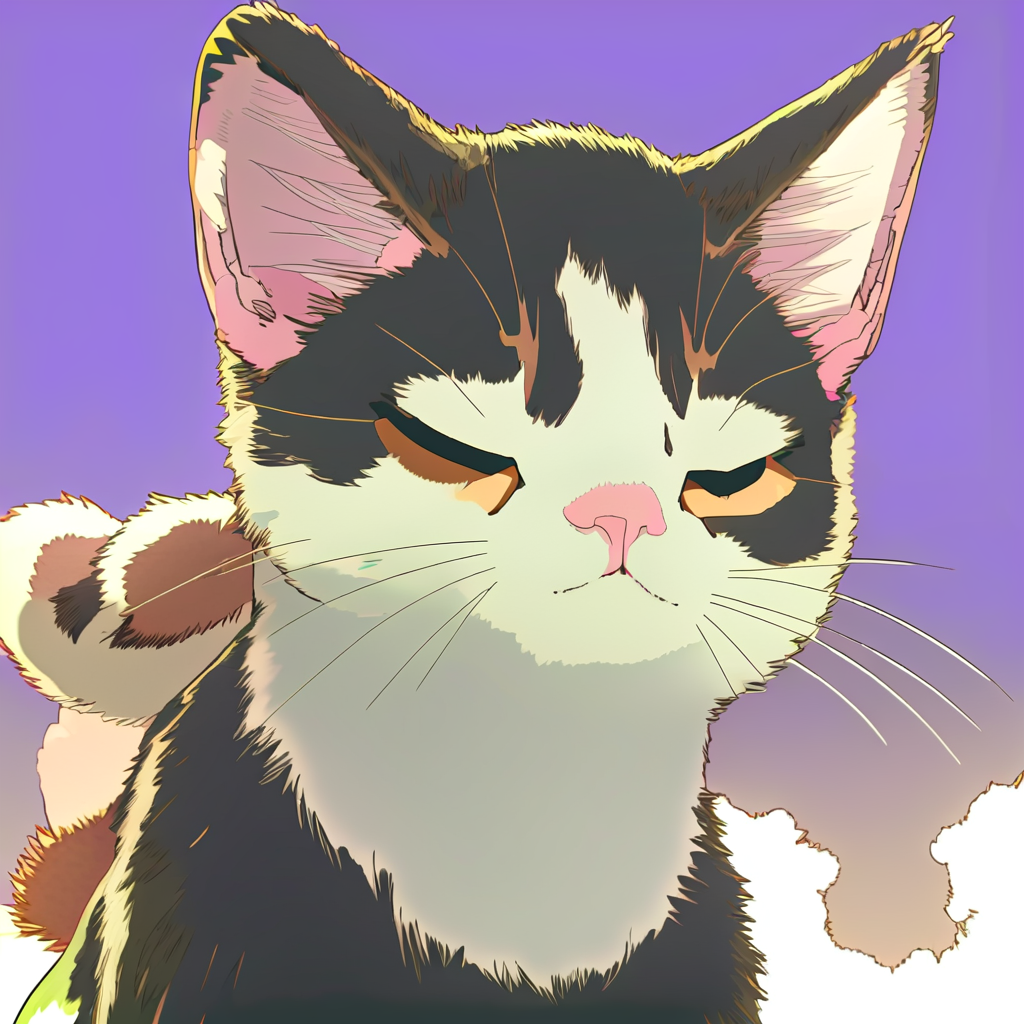

In [27]:
prompt = "an anime version of hawhaw cat"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image